# ライブラリの読み込み

In [86]:
import networkx as nx
from networkx.algorithms import community
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import igraph
import seaborn as sns
%matplotlib inline

ユニバースの情報を取得

In [87]:
df_univ = pd.read_excel("df_univ.xlsx")
df_univ

,CODE,NAME,IND33,IND33_NAME,SIZE_CODE,SIZE,MCAP
0,1301,極洋,50,水産・農林業,7,TOPIX Small 2,251.484793
1,1332,ニッスイ,50,水産・農林業,4,TOPIX Mid400,201.030688
2,1333,マルハニチロ,50,水産・農林業,4,TOPIX Mid400,237.240221
3,1375,雪国まいたけ,50,水産・農林業,7,TOPIX Small 2,25.935481
4,1376,カネコ種苗,50,水産・農林業,7,TOPIX Small 2,105.799271
...,...,...,...,...,...,...,...
2158,9991,ジェコス,6050,卸売業,7,TOPIX Small 2,0.503773
2159,9993,ヤマザワ,6100,小売業,7,TOPIX Small 2,94.119841
2160,9994,やまや,6100,小売業,7,TOPIX Small 2,47.934445
2161,9995,グローセル,6050,卸売業,7,TOPIX Small 2,645.209535


株式保有状況を適当に生成

In [88]:
num_stock_average = 10
df_x_to_y = df_univ[["CODE"]].sample(n = num_stock_average * len(df_univ), replace = True).rename(columns = {"CODE": "CODE_X"})
df_x_to_y["CODE_Y"] = df_univ[["CODE"]].sample(n = num_stock_average * len(df_univ), replace = True).values
df_x_to_y = df_x_to_y[df_x_to_y["CODE_X"] != df_x_to_y["CODE_Y"]].copy()
alpha, beta = 1.0, 10.0
df_x_to_y["RATIO_X_TO_Y"] = np.random.beta(alpha, beta, size = len(df_x_to_y))
df_x_to_y["MCAP_X_TO_Y"] = np.random.lognormal(mean = 3, sigma = 1, size = len(df_x_to_y))

df_x_to_y.reset_index(drop = True)

,CODE_X,CODE_Y,RATIO_X_TO_Y,MCAP_X_TO_Y
0,3639,3607,0.121109,23.131851
1,1377,3996,0.163221,31.143448
2,8077,8600,0.092123,6.729972
3,3097,2379,0.006234,61.228816
4,9765,4440,0.101056,6.977183
...,...,...,...,...
21614,5013,4275,0.090086,10.147577
21615,9265,1899,0.193391,88.183457
21616,4362,9765,0.015703,1.207684
21617,4929,5632,0.192720,20.147284


グラフを作成

In [89]:
G = nx.from_pandas_edgelist(df_x_to_y, source = "CODE_X", target = "CODE_Y",\
                            edge_attr = ["RATIO_X_TO_Y", "MCAP_X_TO_Y"], create_using = nx.DiGraph)
df_univ["COLOR"] = "white"
dict_node_attr = df_univ.set_index('CODE').to_dict('index')
nx.set_node_attributes(G, dict_node_attr)

# グラフのプロット

ある企業に注目した場合

In [90]:
CODE_FOCUS = 7203

# 関数内で処理すると時間がかかってしまう
G_undirected = G.to_undirected()
G_undirected_reciprocal = G.to_undirected(reciprocal = True)

# 着目する企業から(方向を考慮しない)距離がdistance以内である企業を(持ち合い以外の場合も)抽出
def filter_neighbors(node):
    distance = 1
    return (nx.shortest_path_length(G_undirected, source = CODE_FOCUS, target = node) <= distance)

# 上記の中で，持ち合いである場合のみ抽出
def filter_reciprocal_neighbors(node):
    distance = 1
    return (nx.shortest_path_length(G_undirected_reciprocal, source = CODE_FOCUS, target = node) <= distance)

# 持ち合いであるエッジのみを表示
def filter_reciprocal_edge(node1, node2):
    return (nx.is_weighted(G, (node1, node2)) & nx.is_weighted(G, (node2, node1)))

G_focus = nx.subgraph_view(G, filter_node = filter_neighbors)
nx.set_node_attributes(G_focus, name = "COLOR", values = {CODE_FOCUS: "red"})

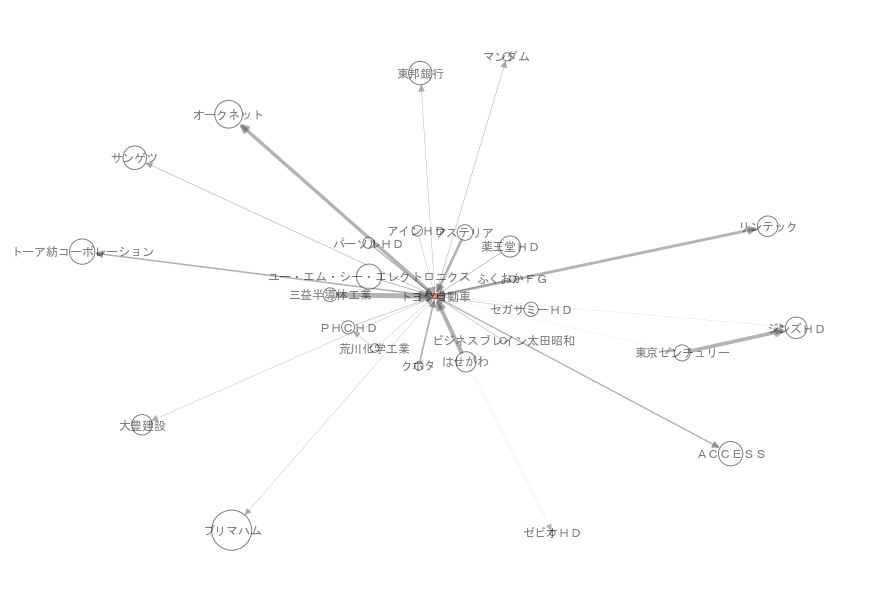

In [127]:
def plot_network(G, alpha, node_scale, node_attr, width_scale, width_attr, arrowsize, seed_for_plot, k_scale):
    fig = plt.figure(figsize = (12, 8))
    # ノードの設定
    edgecolors = "black" # ノードの縁の色(ややこしい)
    node_size = np.sqrt(np.fromiter(nx.get_node_attributes(G, node_attr).values(), dtype = float))*node_scale
    # エッジの設定
    edge_color = "dimgray"
    width = np.fromiter(nx.get_edge_attributes(G, width_attr).values(), dtype = float)*width_scale
    # その他の設定
    pos = nx.spring_layout(G, seed = seed_for_plot, k = k_scale / np.sqrt(G.size()))
    nx.draw(G, with_labels = True, pos = pos,\
        node_size = node_size, node_color = nx.get_node_attributes(G, "COLOR").values(), alpha = alpha, edgecolors = edgecolors, \
        labels = nx.get_node_attributes(G, "NAME"),
        edge_color = edge_color, width = width, arrowsize = arrowsize, font_family = "MS Gothic")

plot_network(G_focus, alpha = 0.5, node_scale = 20, node_attr = "MCAP", \
    width_scale = 15, width_attr = "RATIO_X_TO_Y", arrowsize = 15, \
        seed_for_plot = 300, k_scale = 2.0)

検出されたコミュニティに注目する場合

In [128]:
community = community.greedy_modularity_communities(G_undirected)
print(community[3])

[frozenset({4097, 6146, 4098, 4109, 8214, 6167, 6171, 8219, 8230, 8242, 2109, 8253, 8273, 2130, 4187, 8285, 8289, 2154, 4202, 4204, 2157, 4205, 4206, 8304, 4208, 8306, 6268, 4221, 2175, 2180, 4229, 2183, 8331, 8336, 6291, 2198, 8343, 8345, 2201, 4251, 6301, 2209, 6305, 8358, 8361, 8362, 8364, 8365, 8368, 8369, 6328, 8377, 6330, 4286, 8383, 8386, 4290, 4295, 4301, 6349, 8399, 6351, 4312, 2264, 6361, 2267, 2269, 4318, 6367, 6369, 6370, 4326, 6376, 2282, 6387, 2292, 6390, 8439, 2296, 4345, 4346, 4348, 2307, 4362, 2317, 6413, 6420, 2325, 4373, 2331, 4382, 2337, 4385, 4390, 2353, 4410, 6459, 6462, 6463, 6465, 8515, 2372, 2374, 6471, 6472, 8521, 6473, 6474, 2379, 6480, 4432, 2389, 4440, 4446, 4449, 2410, 2412, 4463, 4465, 8562, 8563, 6517, 2432, 4483, 6535, 2440, 8585, 6540, 8593, 8595, 6552, 8601, 6555, 8604, 6560, 2471, 4519, 4523, 2475, 4527, 4531, 6588, 4541, 4543, 6592, 2501, 4554, 4559, 4577, 4578, 2533, 4581, 2540, 8698, 6654, 8706, 4611, 4619, 4620, 6675, 6676, 6678, 4636, 2593, 4641

In [130]:
node_list = community[5]

frozenset({9312, 3302, 5480, 1433, 4298, 5803})


In [132]:
# 着目する企業から(方向を考慮しない)距離がdistance以内である企業を(持ち合い以外の場合も)抽出
def filter_neighbors(node):
    distance = 1
    flag = False
    for node_c in node_list:
        flag = (flag | nx.shortest_path_length(G_undirected, source = node_c, target = node) <= distance)
    return flag

G_focus = nx.subgraph_view(G, filter_node = filter_neighbors)
dict_color = dict(zip(node_list, ["red" for _ in range(len(node_list))]))
nx.set_node_attributes(G_focus, name = "COLOR", values = dict_color)

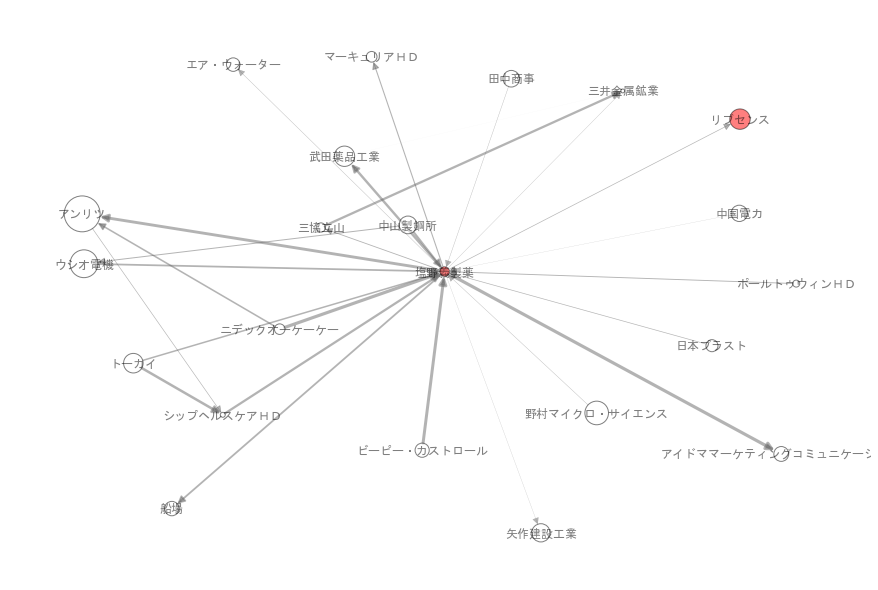

In [137]:
plot_network(G_focus, alpha = 0.5, node_scale = 20, node_attr = "MCAP", \
    width_scale = 15, width_attr = "RATIO_X_TO_Y", arrowsize = 15, \
        seed_for_plot = 300, k_scale = 5.0)

In [134]:
G_focus.size()

27